In [102]:
import torch
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.utils import _pair
import torch.nn as nn
import torch
from torch.autograd import Variable
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.random import rand, randn

class MyGabor(_ConvNd):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=False):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        
        super(MyGabor, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation,False, _pair(0), groups, bias)
        
        # TODO: подумать над инициализацией параметров
        self.sigma_x = nn.Parameter(kernel_size[0]/5*torch.rand(in_channels,out_channels))
        self.sigma_y = nn.Parameter(kernel_size[0]/5*torch.rand(in_channels,out_channels))
        self.freq = nn.Parameter(kernel_size[0]*torch.rand(in_channels,out_channels))
        self.theta = nn.Parameter(3.14*torch.rand(in_channels,out_channels))
        self.psi = nn.Parameter(3.14*torch.rand(in_channels,out_channels))
        #self.evaluate = False
    
    #def eval(self):
        #self.evaluate = True
        
    #def train(self):
        #self.evaluate = False
        
    def forward(self, input):
        
        '''if self.evaluate == True:
            return F.conv2d(input, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)'''
        
        x0 = torch.ceil(torch.Tensor([self.kernel_size[0]/2]))[0]
        y0 = torch.ceil(torch.Tensor([self.kernel_size[1]/2]))[0]
        
        weight = torch.empty(self.weight.shape, requires_grad=False)
        for i in range(self.in_channels):
            for j in range(self.out_channels):
                y, x = torch.meshgrid([torch.arange(-y0+1,y0), torch.arange(-x0+1,x0)])
                sigma_x = self.sigma_x[i,j].expand_as(y)
                sigma_y = self.sigma_y[i,j].expand_as(y)
                freq = self.freq[i,j].expand_as(y)
                theta = self.theta[i,j].expand_as(y)
                psi = self.psi[i,j].expand_as(y)
                
                rotx = x * torch.cos(theta) + y * torch.sin(theta)
                roty = -x * torch.sin(theta) + y * torch.cos(theta) 
                g = torch.zeros(y.shape)
                g = torch.exp(-0.5 * (rotx ** 2 / (sigma_x + 1e-3) ** 2 + roty ** 2 / (sigma_y + 1e-3) ** 2))
                g = g * torch.cos(2 * 3.14 * freq * rotx + psi) #/ (2*3.14*sigma_x*sigma_y)
                weight[j,i] = g
                self.weight.data[j,i] = g    
        return F.conv2d(input, weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

In [115]:
Teacher_layer = MyGabor(1,1, kernel_size=15)
Learner_layer = MyGabor(1,1, kernel_size=15)

In [116]:
print(Teacher_layer.theta,Teacher_layer.sigma_x,Teacher_layer.sigma_y, Teacher_layer.freq)

Parameter containing:
tensor([[2.0733]], requires_grad=True) Parameter containing:
tensor([[4.5543]], requires_grad=True) Parameter containing:
tensor([[0.9744]], requires_grad=True) Parameter containing:
tensor([[8.0350]], requires_grad=True)


In [117]:
print(Learner_layer.theta,Learner_layer.sigma_x,Learner_layer.sigma_y,Learner_layer.freq)

Parameter containing:
tensor([[0.3724]], requires_grad=True) Parameter containing:
tensor([[3.4283]], requires_grad=True) Parameter containing:
tensor([[3.4171]], requires_grad=True) Parameter containing:
tensor([[8.2476]], requires_grad=True)


In [118]:
img = cv2.imread('cat.jpg',0)
img = cv2.resize(img, (100, 100))

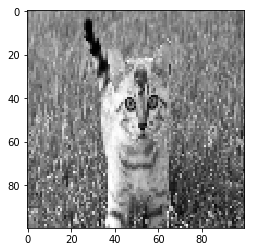

In [119]:
plt.imshow(img, cmap = 'gray')
plt.show()

In [120]:
img = torch.Tensor(img).unsqueeze(0).unsqueeze(0)/255

In [121]:
out1 = Teacher_layer(img).detach()

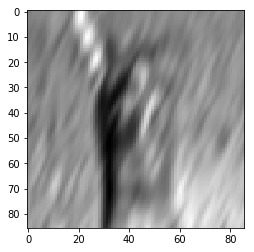

In [122]:
plt.imshow(out1[0][0].detach().numpy(), cmap = 'gray')
plt.show()

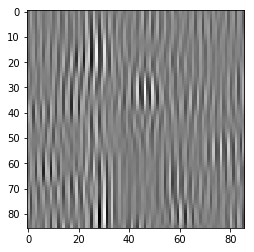

In [123]:
out2 = Learner_layer(img).detach()
plt.imshow(out2[0][0].detach().numpy(), cmap = 'gray')
plt.show()

1000 tensor(5.3410, grad_fn=<L1LossBackward>)
2000 tensor(4.1220, grad_fn=<L1LossBackward>)
3000 tensor(3.3285, grad_fn=<L1LossBackward>)
4000 tensor(2.7944, grad_fn=<L1LossBackward>)
5000 tensor(2.4348, grad_fn=<L1LossBackward>)
6000 tensor(2.1978, grad_fn=<L1LossBackward>)
7000 tensor(2.0482, grad_fn=<L1LossBackward>)
8000 tensor(1.9520, grad_fn=<L1LossBackward>)
9000 tensor(1.8857, grad_fn=<L1LossBackward>)
10000 tensor(1.8434, grad_fn=<L1LossBackward>)
11000 tensor(1.8174, grad_fn=<L1LossBackward>)
12000 tensor(1.8021, grad_fn=<L1LossBackward>)
13000 tensor(1.7932, grad_fn=<L1LossBackward>)
14000 tensor(1.7881, grad_fn=<L1LossBackward>)
15000 tensor(1.7850, grad_fn=<L1LossBackward>)
16000 tensor(1.7827, grad_fn=<L1LossBackward>)
17000 tensor(1.7805, grad_fn=<L1LossBackward>)
18000 tensor(1.7780, grad_fn=<L1LossBackward>)
19000 tensor(1.7754, grad_fn=<L1LossBackward>)
20000 tensor(1.7728, grad_fn=<L1LossBackward>)
21000 tensor(1.7706, grad_fn=<L1LossBackward>)
22000 tensor(1.7687, g

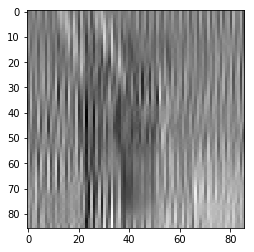

In [124]:
criterion = nn.L1Loss()
opt = torch.optim.Adam(Learner_layer.parameters())
for i in range(50000):
    opt.zero_grad()
    
    out2 = Learner_layer(img)
    
    loss = criterion(out2, out1)
    
    loss.backward()
    
    opt.step()
    
    if i%1000 == 999:
        print(i+1, loss)
        
print(Teacher_layer.theta,Teacher_layer.sigma_x,Teacher_layer.sigma_y, Teacher_layer.freq)
print()
print(Learner_layer.theta,Learner_layer.sigma_x,Learner_layer.sigma_y,Learner_layer.freq)
out2 = Learner_layer(img).detach()
plt.imshow(out2[0][0].detach().numpy(), cmap = 'gray')
plt.show()

Parameter containing:
tensor([[2.0733]], requires_grad=True) Parameter containing:
tensor([[4.5543]], requires_grad=True) Parameter containing:
tensor([[0.9744]], requires_grad=True) Parameter containing:
tensor([[8.0350]], requires_grad=True)

Parameter containing:
tensor([[0.3738]], requires_grad=True) Parameter containing:
tensor([[43.7436]], requires_grad=True) Parameter containing:
tensor([[7.6699]], requires_grad=True) Parameter containing:
tensor([[8.2010]], requires_grad=True)


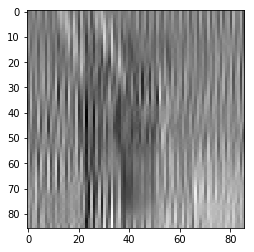

In [125]:
print(Teacher_layer.theta,Teacher_layer.sigma_x,Teacher_layer.sigma_y, Teacher_layer.freq)
print()
print(Learner_layer.theta,Learner_layer.sigma_x,Learner_layer.sigma_y,Learner_layer.freq)
out2 = Learner_layer(img).detach()
plt.imshow(out2[0][0].detach().numpy(), cmap = 'gray')
plt.show()

In [126]:
Learner_layer_conv = nn.Conv2d(1,1, kernel_size=15)

1000 tensor(6.3657, grad_fn=<SmoothL1LossBackward>)
2000 tensor(6.3657, grad_fn=<SmoothL1LossBackward>)
3000 tensor(6.3657, grad_fn=<SmoothL1LossBackward>)
4000 tensor(6.3657, grad_fn=<SmoothL1LossBackward>)
5000 tensor(6.3657, grad_fn=<SmoothL1LossBackward>)
6000 tensor(6.3657, grad_fn=<SmoothL1LossBackward>)
7000 tensor(6.3657, grad_fn=<SmoothL1LossBackward>)
8000 tensor(6.3657, grad_fn=<SmoothL1LossBackward>)
9000 tensor(6.3657, grad_fn=<SmoothL1LossBackward>)
10000 tensor(6.3657, grad_fn=<SmoothL1LossBackward>)
11000 tensor(6.3657, grad_fn=<SmoothL1LossBackward>)
12000 tensor(6.3657, grad_fn=<SmoothL1LossBackward>)
13000 tensor(6.3657, grad_fn=<SmoothL1LossBackward>)
14000 tensor(6.3657, grad_fn=<SmoothL1LossBackward>)
15000 tensor(6.3657, grad_fn=<SmoothL1LossBackward>)
16000 tensor(6.3657, grad_fn=<SmoothL1LossBackward>)
17000 tensor(6.3657, grad_fn=<SmoothL1LossBackward>)
18000 tensor(6.3657, grad_fn=<SmoothL1LossBackward>)
19000 tensor(6.3657, grad_fn=<SmoothL1LossBackward>)
20

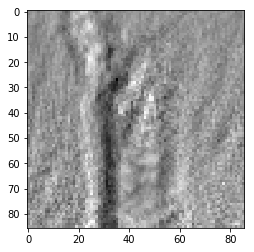

In [127]:
criterion = nn.SmoothL1Loss()
opt = torch.optim.Adam(Learner_layer.parameters())
for i in range(50000):
    opt.zero_grad()
    
    out3 = Learner_layer_conv(img)
    
    loss = criterion(out3, out1)
    
    loss.backward()
    
    opt.step()
    
    if i%1000 == 999:
        print(i+1, loss)
        
out3 = Learner_layer_conv(img).detach()
plt.imshow(out3[0][0].detach().numpy(), cmap = 'gray')
plt.show()

In [101]:
img

tensor([[[[0.5216, 0.5608, 0.4667,  ..., 0.4353, 0.4627, 0.5608],
          [0.5333, 0.6431, 0.5216,  ..., 0.4196, 0.4549, 0.5765],
          [0.5255, 0.6510, 0.5020,  ..., 0.3647, 0.4196, 0.6039],
          ...,
          [0.4000, 0.5333, 0.5804,  ..., 0.3490, 0.3686, 0.5490],
          [0.3137, 0.4824, 0.4824,  ..., 0.3843, 0.5961, 0.3529],
          [0.3961, 0.4588, 0.4941,  ..., 0.4000, 0.2196, 0.3804]]]])